# Deep Deterministic Policy Gradient for Portfolio Management

**Steps to try:**
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

**Possible improvement methods:**
1. Use correlated action noise
2. Use adaptive parameter noise

**Figures to show:**
1. Training: total rewards w.r.t episode
2. How the model performs on training data
3. How the model performs on testing data

## Setup

In [7]:
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
import pickle
# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [9]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
with open('utils/datasets/all_eqw','rb') as fr:
    history=pickle.load(fr,encoding='latin1')

with open('utils/datasets/stock_names','rb') as fr:
    abbreviation=pickle.load(fr,encoding='latin1')
history = history[:, :, :4]
num_training_time = history.shape[1]
num_testing_time = history.shape[1]
window_length = 3

In [10]:
# get target history
#target_stocks = ['AAPL', 'COST', 'DISH']
target_stocks = ['BLK UN EQUITY','GS UN EQUITY','USB UN EQUITY']

target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

In [11]:
# collect testing data
#testing_stocks = ['CMCSA', 'GOOGL', 'EBAY']
testing_stocks = ['AMG UN EQUITY', 'BRK/B UN EQUITY', 'MTB UN EQUITY', ]

testing_history = np.empty(shape=(len(testing_stocks), num_testing_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), :num_testing_time, :]

In [12]:
# dataset for 16 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
with open('utils/datasets/all_eqw', 'rb') as fr:
    history = pickle.load(fr, encoding='latin1')

with open('utils/datasets/stock_names', 'rb') as fr:
    abbreviation = pickle.load(fr, encoding='latin1')
history = history[:, :, :4]

# 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [13]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(16, 1095, 4)
(16, 1785, 4)


In [14]:
# visualize 3 stock open price
if False:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_stocks)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_stocks[i])
        plt.show()

## Load Models

In [15]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN

In [16]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [17]:
models = []
model_names = []
window_length_lst = [3, 7, 14, 21]
predictor_type_lst = ['cnn', 'lstm']
use_batch_norm = True

In [18]:
for window_length in window_length_lst:
    name = 'imit_LSTM%3A window = {}'.format(window_length)
    model_name = 'imitation_lstm_window_{}'.format(window_length)
    model_names.append(model_name)
    # instantiate LSTM model
    lstm_model = StockLSTM(nb_classes, window_length, weights_file = 'weights/' + name + '.h5')
    lstm_model.build_model(load_weights=True)
    models.append(lstm_model)
    
    name = 'imit_CNN%3A window = {}'.format(window_length)
    model_name = 'imitation_cnn_window_{}'.format(window_length)
    model_names.append(model_name)
    # instantiate CNN model
    cnn_model = StockCNN(nb_classes, window_length, weights_file = 'weights/' + name + '.h5')
    cnn_model.build_model(load_weights=True)
    models.append(cnn_model)

Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model


In [20]:
# instantiate environment, 3 stocks, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt
1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt
1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_7/batch_norm/checkpoint.ckpt
1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_7/batch_norm/checkpoint.ckpt
1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_14/batch_norm/checkpoint.ckpt
1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_14/batch_norm/checkpoint.ckpt
1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_21/batch_norm/checkpoint.ckpt
1.0
1.0
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_21/batch_norm/checkpoint.ckpt


In [45]:
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:8], steps=950, 
                              sample_start_date='2012-10-30')

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00919082  0.0552126   0.0353296   0.01573803  0.02207065  0.02532757
   0.08625302  0.19584338  0.02034662  0.09592073  0.01137672  0.03682399
   0.14940357  0.03113644  0.04530134  0.14560771  0.01911734]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.04223496  0.06735791  0.04723224  0.05007619  0.03993265  0.04125342
   0.08885738  0.08184592  0.04946425  0.08985344  0.03557235  0.05949566
   0.07813734  0.03996174  0.0548212   0.09165218  0.0422512 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.          0.
   0.      

   0.08157984  0.04177114  0.05711725  0.08428943  0.04380772]]
before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0029527   0.09107984  0.04037062  0.02546991  0.00430459  0.01040526
   0.06397758  0.28522688  0.02758394  0.08576041  0.00357594  0.05039844
   0.0907114   0.00811165  0.00509141  0.19198629  0.01299313]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03236423  0.07088957  0.04302953  0.04904157  0.03874961  0.04185464
   0.08872533  0.08107612  0.04765899  0.09809144  0.03167667  0.05693006
   0.07976248  0.03935702  0.05606228  0.10594372  0.03878672]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.        

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00455071  0.10624573  0.02501914  0.03939855  0.00645461  0.02898444
   0.09150761  0.1723084   0.04351842  0.0657335   0.00503143  0.03553083
   0.11314646  0.01399896  0.01413832  0.22391701  0.01051593]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02565562  0.06993687  0.03673465  0.04383463  0.03815279  0.0348397
   0.11248374  0.08219744  0.04073307  0.1015869   0.02783838  0.05347697
   0.10456097  0.03575384  0.05639016  0.10551404  0.03031023]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

   0.08940054  0.03998885  0.05295013  0.08957044  0.04176642]]
before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02054044  0.06235551  0.02555736  0.02189682  0.03224503  0.05688772
   0.16016346  0.05540425  0.04321304  0.07955983  0.02734803  0.08033805
   0.10362147  0.06572612  0.04613507  0.10717584  0.01183202]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03870815  0.06636877  0.04880016  0.04598451  0.04207367  0.03795032
   0.08455422  0.08757492  0.05279263  0.09375621  0.03493391  0.06502341
   0.08000208  0.03850498  0.05503654  0.09361539  0.03432011]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.        

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01292121  0.06238654  0.04982023  0.0235899   0.03258466  0.03670306
   0.08095015  0.1567151   0.04742562  0.08362214  0.02318972  0.04625311
   0.12233331  0.05541956  0.04951316  0.08746251  0.02910995]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03724035  0.06881003  0.0499784   0.04768559  0.0479536   0.0433315
   0.08119694  0.08798218  0.04838657  0.0833114   0.04053459  0.05725177
   0.0818198   0.04324932  0.05593151  0.08452604  0.04081033]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.04122112  0.09150901  0.05853743  0.02310816  0.03109103  0.01913471
   0.08017835  0.12265749  0.04532709  0.09075021  0.05178324  0.14281346
   0.05646085  0.0408769   0.01197668  0.06860535  0.02396884]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.0376015   0.06448148  0.04450083  0.04743052  0.03639708  0.04326501
   0.08741912  0.08259814  0.04972421  0.0995967   0.03339004  0.05947231
   0.07346517  0.03777506  0.05329451  0.10962244  0.03996583]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01233303  0.06431504  0.02575736  0.03825582  0.02169922  0.04302443
   0.12462811  0.0831883   0.01970155  0.08496264  0.01414294  0.04676951
   0.10863395  0.02440725  0.03260861  0.23434594  0.02122632]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02921798  0.05885191  0.03463165  0.0434796   0.03008479  0.03387778
   0.10132195  0.08032422  0.04671239  0.10877317  0.02451818  0.05125165
   0.06907243  0.03085306  0.05489941  0.1575084   0.04462147]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01527712  0.06908175  0.10238955  0.01659367  0.01480081  0.02681852
   0.09305336  0.13059592  0.08022081  0.09338851  0.04391399  0.10074033
   0.05444025  0.03204349  0.009362    0.08624724  0.03103271]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03588955  0.06627526  0.0452032   0.04776601  0.03890295  0.04448548
   0.08446566  0.08043077  0.04929054  0.09697558  0.03479157  0.05992319
   0.07822554  0.04010847  0.0553847   0.10302131  0.03886028]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.01617095  0.03923638  0.03792164  0.01687678  0.0951016   0.02979328
   0.07005661  0.04309284  0.04398803  0.11345906  0.06495976  0.06435248
   0.09303749  0.0623658   0.03956875  0.07894694  0.09107161]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03073834  0.06972528  0.04008988  0.04684038  0.04117726  0.03980491
   0.09360366  0.08975115  0.0442945   0.09249169  0.03438449  0.05655479
   0.09183343  0.03755028  0.05551237  0.09913468  0.03651288]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01264046  0.05934512  0.03680633  0.02349924  0.03624271  0.05792656
   0.10508794  0.10449739  0.03240686  0.0531373   0.02123395  0.03592586
   0.18691897  0.03907124  0.03766558  0.13702616  0.0205683 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02996623  0.07064389  0.04254869  0.04192034  0.05016223  0.0248318
   0.08973497  0.13019058  0.03489527  0.08475112  0.03310126  0.06264083
   0.12248538  0.03461536  0.04703347  0.07448149  0.02599715]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.106503    0.0876975   0.02932806  0.00375275  0.06535394  0.04066607
   0.03283402  0.04188873  0.02710829  0.06879084  0.27827233  0.03038708
   0.02913802  0.02090835  0.02581608  0.08527528  0.02627956]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04113548  0.06800926  0.04828566  0.0504089   0.04492072  0.04587657
   0.08495334  0.08103829  0.04668662  0.08363     0.04089908  0.05880923
   0.08237477  0.04128044  0.05303559  0.0876882   0.04096785]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.06668431  0.12954025  0.03525981  0.01392994  0.04139207  0.10909519
   0.06233134  0.05966956  0.03724033  0.06339731  0.04298354  0.02748343
   0.10364176  0.026087    0.03430936  0.13513225  0.01182253]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03725017  0.06762406  0.04388558  0.05039708  0.03851033  0.04850587
   0.09088811  0.07330006  0.04896931  0.093242    0.03391962  0.05590039
   0.07501476  0.04125028  0.05516446  0.10192063  0.04425725]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.01431877  0.02612169  0.02443941  0.00464252  0.03723492  0.09435143
   0.07182164  0.08922537  0.01268321  0.04778032  0.02417122  0.01371058
   0.16588081  0.04069164  0.12376446  0.16289736  0.04626467]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03326093  0.07671428  0.04232791  0.04839583  0.04984544  0.04092119
   0.08625818  0.08289138  0.04346031  0.08921888  0.03599714  0.05570912
   0.10144264  0.04275555  0.05544379  0.08015127  0.03520617]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  8.95416015e-04   1.36694442e-02   1.30187916e-02   3.69420100e-04
    2.65685096e-03   7.22173182e-03   4.23260592e-03   2.67977238e-01
    6.89460188e-02   3.83461386e-01   4.06213151e-03   1.40610244e-02
    1.61853097e-02   8.47821310e-03   1.88158639e-02   1.57935783e-01
    1.80127285e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.03348098e-02   6.61875755e-02   4.30683158e-02   4.52326536e-02
    3.094

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00190018  0.05522536  0.04690473  0.11167599  0.01626372  0.00428365
   0.19294994  0.09636568  0.00607333  0.09326895  0.00108385  0.0189901
   0.2646648   0.00802189  0.00729539  0.07308582  0.00194662]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03034169  0.07616778  0.04481375  0.04378759  0.04677756  0.03461971
   0.08267095  0.1021586   0.04152286  0.09505906  0.0331654   0.05929004
   0.11039536  0.03901104  0.05072275  0.07957202  0.0299239 ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.06318595  0.08937668  0.03620651  0.01721286  0.06523492  0.084752
   0.10687755  0.03138966  0.03604229  0.07032943  0.05802139  0.03986563
   0.08615644  0.02997967  0.03382096  0.13337615  0.0181719 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04059274  0.06467594  0.04776462  0.04946956  0.04124057  0.04771247
   0.08338741  0.07758201  0.05387337  0.08974323  0.03759242  0.05964105
   0.07088792  0.04104125  0.0543541   0.09833699  0.04210427]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00442312  0.03133892  0.05139196  0.00968476  0.03693185  0.00513213
   0.02866122  0.21185452  0.00408312  0.13018344  0.00606821  0.02944928
   0.30231529  0.01308291  0.0140862   0.0985219   0.02279116]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02927332  0.06230368  0.04881564  0.03798301  0.03576513  0.03081974
   0.07145943  0.14130162  0.03861126  0.10636792  0.03014867  0.05828745
   0.09425116  0.03666435  0.05014994  0.09237399  0.03542362]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0922765   0.10180523  0.01698399  0.01041335  0.07005902  0.05014699
   0.06403527  0.05046352  0.01082249  0.06943522  0.02346778  0.04409132
   0.19572616  0.02593499  0.02839062  0.13820903  0.00773847]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03843667  0.06487004  0.04637422  0.04383131  0.03501176  0.03714924
   0.08355468  0.09897546  0.04339363  0.09944329  0.03094954  0.05753328
   0.07993687  0.03640261  0.0539123   0.1049192   0.0453059 ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01647755  0.08424358  0.03995529  0.01404886  0.01151048  0.04897381
   0.07347935  0.15618108  0.10565665  0.10014444  0.02254045  0.06546344
   0.05152113  0.04228652  0.03169401  0.12119194  0.01463137]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03898552  0.06737385  0.04541928  0.04883352  0.04244078  0.04712724
   0.08704762  0.07381581  0.05260948  0.09283572  0.03596881  0.05793141
   0.07830504  0.04355014  0.05492455  0.09413561  0.0386956 ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.02242431  0.11493896  0.02715958  0.01663365  0.02415381  0.05844794
   0.08883093  0.06834247  0.05914931  0.09812728  0.03022898  0.03803788
   0.08765996  0.04423847  0.06792729  0.14353812  0.01016097]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03771898  0.0688351   0.04689562  0.048076    0.0409335   0.04625422
   0.08503228  0.07934155  0.04828091  0.0952678   0.03470949  0.05788385
   0.08207798  0.0421463   0.05341058  0.09441657  0.03871934]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.0093751   0.05319561  0.03925426  0.00504897  0.01416626  0.01320506
   0.03330761  0.29284343  0.05095553  0.17564178  0.02785875  0.05873918
   0.04330796  0.0421505   0.03191156  0.08265837  0.02638002]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02952577  0.06460484  0.04644957  0.04332488  0.03504184  0.03644402
   0.08388866  0.11010151  0.04568131  0.11340071  0.03243817  0.06190017
   0.08553226  0.03537817  0.04984793  0.09770805  0.02873214]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01386595  0.05674738  0.04242866  0.02846206  0.01970111  0.026998
   0.05188857  0.1159545   0.10795877  0.19816832  0.01329887  0.05917119
   0.05288034  0.04825605  0.04259699  0.10549935  0.01612387]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02643477  0.06050773  0.03398949  0.04300525  0.02677228  0.03869447
   0.09711734  0.094756    0.04603789  0.1436571   0.02463559  0.0573943
   0.09205481  0.0334631   0.04400991  0.11071458  0.02675534]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.         

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00636906  0.08049172  0.04041821  0.01509467  0.0052808   0.0579908
   0.03745145  0.18417272  0.09511055  0.06490515  0.01233477  0.04545644
   0.06200681  0.02469129  0.02373131  0.21676242  0.02773165]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03420656  0.06828634  0.04559852  0.04700378  0.03951521  0.04258763
   0.0903923   0.07758994  0.05034335  0.09582026  0.03243817  0.05854594
   0.07625069  0.04003399  0.05679856  0.10684674  0.03774199]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03899954  0.09100195  0.0661317   0.00666807  0.02058196  0.01191095
   0.04672502  0.26580569  0.0356963   0.08348273  0.07660997  0.09816411
   0.03590485  0.02685845  0.01072169  0.05746184  0.02727519]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03871777  0.06798565  0.05327689  0.04495079  0.04182239  0.04077585
   0.07467038  0.09666928  0.04928847  0.09356897  0.03750083  0.06598534
   0.08223692  0.04111959  0.0532173   0.08321394  0.03499971]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02106111  0.06816047  0.04256818  0.03795903  0.04642278  0.03521411
   0.06063335  0.08166327  0.04885428  0.15091412  0.02403071  0.04477017
   0.09224156  0.0362162   0.04342072  0.12275001  0.04312002]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03304927  0.05922693  0.04041107  0.04432078  0.03367588  0.04190949
   0.0881341   0.08499172  0.04626446  0.10518006  0.02992883  0.0571361
   0.07895254  0.03763614  0.05351203  0.12397397  0.04169662]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01442339  0.06608182  0.06148969  0.0123752   0.01415127  0.02032835
   0.10676533  0.26141217  0.01583568  0.07579736  0.0131093   0.04611458
   0.09772693  0.01918924  0.01664656  0.1425343   0.01601881]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03306274  0.06316175  0.05088733  0.04183165  0.03825839  0.03497976
   0.07736299  0.11448626  0.04449122  0.09674042  0.03325444  0.06283691
   0.08558264  0.03540883  0.05181054  0.0980133   0.03783077]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

   0.08188498  0.04487243  0.05381646  0.08267454  0.04477414]]
before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.04097917  0.0744433   0.03396703  0.01447265  0.04091907  0.05562546
   0.08086286  0.07241313  0.04861342  0.10578691  0.06030024  0.03711344
   0.07406624  0.03324108  0.05370243  0.15125737  0.02223619]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03857376  0.06430899  0.04153404  0.05123963  0.04605236  0.04172501
   0.09412123  0.08155934  0.04437296  0.0864931   0.03891687  0.06137565
   0.09421866  0.03951691  0.05202198  0.08853043  0.03543909]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.        

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02810443  0.05397521  0.01302557  0.03617828  0.0507721   0.00446562
   0.16543762  0.01417605  0.01546645  0.09655616  0.015802    0.37207955
   0.05237686  0.02577384  0.00184505  0.05094182  0.00302335]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04090441  0.06883185  0.04578452  0.05295795  0.04337547  0.04117051
   0.08727229  0.07690546  0.05660683  0.09280517  0.03747035  0.06691775
   0.07359421  0.04073473  0.05512058  0.08528459  0.03426335]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03317456  0.0868046   0.03916931  0.01917734  0.02830624  0.08774535
   0.11863041  0.06799443  0.05715102  0.07618719  0.0359973   0.03766742
   0.08361194  0.04079566  0.05000412  0.12575984  0.01182328]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04224025  0.06751833  0.04563775  0.05050313  0.04073128  0.04473585
   0.09031858  0.07202479  0.05695817  0.09280401  0.03551302  0.05796736
   0.07216888  0.04258839  0.05450305  0.09280937  0.04097767]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00887175  0.04547632  0.0724915   0.01278208  0.01200332  0.02040057
   0.10647956  0.21673752  0.01103513  0.07997034  0.01430453  0.03346694
   0.0863053   0.01822075  0.02987426  0.19541487  0.0361653 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03038969  0.06278723  0.04983159  0.03927542  0.03752632  0.03180652
   0.07592761  0.12721296  0.04026287  0.09681503  0.03117199  0.06091354
   0.09346032  0.03503999  0.0505281   0.10023645  0.03681436]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01357811  0.05648748  0.04697881  0.07407743  0.05747428  0.01211031
   0.09585561  0.0993678   0.01077394  0.11930352  0.00775645  0.03641119
   0.18649364  0.02397338  0.03538815  0.10410914  0.0198609 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02936926  0.07156383  0.03720243  0.04524403  0.04519848  0.04009934
   0.0940165   0.08235427  0.04007255  0.09049466  0.03292394  0.05074487
   0.11232515  0.04033787  0.05484029  0.09556573  0.03764677]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02246896  0.06450584  0.04329436  0.01458172  0.04975437  0.04183176
   0.06758208  0.09268905  0.04659056  0.12182825  0.05528376  0.04419657
   0.09698077  0.04753063  0.0551952   0.10318395  0.03250216]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04275932  0.06772709  0.04747933  0.05143322  0.04187501  0.04502193
   0.08714174  0.07615022  0.05251659  0.09137595  0.03722132  0.06186468
   0.0771226   0.04171424  0.05344756  0.08622416  0.03892512]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00516844  0.05215516  0.08978927  0.01036899  0.01244891  0.00953325
   0.04157404  0.46335393  0.01193544  0.03912317  0.01224295  0.02502114
   0.1085481   0.02428464  0.01497427  0.05424454  0.02523375]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02313462  0.06900534  0.04639604  0.03445224  0.04199729  0.02332967
   0.07381659  0.1646625   0.02936195  0.0879043   0.0291001   0.05732453
   0.14230374  0.03124953  0.03863659  0.08059511  0.02672978]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00720681  0.03159823  0.03171152  0.02231992  0.04063652  0.03081497
   0.12787656  0.1213444   0.00965646  0.09230407  0.00687703  0.03170762
   0.24461581  0.02499957  0.03023801  0.12820847  0.01788405]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03621563  0.06147633  0.04068974  0.04738192  0.04426887  0.03600212
   0.07976089  0.1013046   0.03657149  0.08890222  0.04039675  0.0654926
   0.1294236   0.03805488  0.0407645   0.08385832  0.0294356 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.18635464  0.17716931  0.0149259   0.00779972  0.07723595  0.0590493
   0.0462955   0.02708101  0.00973391  0.04979676  0.02932199  0.02031162
   0.12667014  0.00940638  0.01334954  0.14303024  0.00246802]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03688026  0.06945024  0.04677582  0.04824292  0.04002954  0.04559285
   0.08980291  0.07981598  0.04712916  0.09774202  0.0328642   0.05742125
   0.0823531   0.04166127  0.05290712  0.09329528  0.03803609]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.61009302e-04   9.56202485e-03   1.81408636e-02   1.06250187e-02
    1.85742136e-02   8.39281478e-04   2.05392316e-02   1.31555840e-01
    5.57953585e-03   4.08196300e-01   3.67040280e-04   4.06507775e-03
    2.48530194e-01   7.11723976e-03   3.03212330e-02   7.47432485e-02
    1.10827107e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  3.16786543e-02   6.32945374e-02   4.64324132e-02   4.20949459e-02
    3.286

   0.0844916   0.04255379  0.05512596  0.08575226  0.04222377]]
before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02170523  0.07979928  0.04269085  0.03032185  0.02569969  0.0378679
   0.17024183  0.08422129  0.0524874   0.09383179  0.02536408  0.06458639
   0.08069295  0.04129259  0.03234518  0.10683087  0.01002092]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03626714  0.06821085  0.0485079   0.04659898  0.04081624  0.0394422
   0.08558696  0.09318239  0.04504448  0.09421514  0.03417614  0.05864566
   0.08629363  0.03964201  0.05506013  0.09031218  0.03799801]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01683151  0.06064043  0.05263114  0.01645648  0.02166918  0.02981018
   0.12684444  0.18725838  0.01975352  0.06868464  0.0184071   0.03898429
   0.11611091  0.02950956  0.04014228  0.13560133  0.02066469]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.0382913   0.06448293  0.04727746  0.04807439  0.03885961  0.04162176
   0.09072764  0.08653855  0.04462955  0.09047104  0.03514349  0.05879248
   0.08477454  0.03846507  0.05420029  0.09549553  0.04215435]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00406807  0.02251664  0.02322793  0.0064746   0.0164506   0.03347072
   0.0278878   0.06452099  0.10610481  0.15368119  0.00836802  0.00899169
   0.0504116   0.06298249  0.29222041  0.09506051  0.02356196]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03182991  0.06367771  0.03701524  0.04653592  0.03723044  0.04061364
   0.10437319  0.06930511  0.04847397  0.10103904  0.02936587  0.05438595
   0.08761373  0.04032508  0.05766468  0.11213637  0.03841413]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02299242  0.06761638  0.0450986   0.01460172  0.02622462  0.03046682
   0.07399392  0.1127337   0.03996647  0.17346452  0.02953846  0.04241239
   0.06931834  0.02309832  0.03194241  0.17082143  0.02570951]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03209095  0.06341412  0.04714522  0.04256091  0.03716439  0.03759968
   0.08037338  0.1091758   0.04334757  0.09913719  0.03291586  0.05606719
   0.08159427  0.03716598  0.05414652  0.10591957  0.0401814 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.05264422  0.07141297  0.06567139  0.00507828  0.06992964  0.09784845
   0.03848593  0.12396722  0.01356092  0.04067392  0.04361654  0.0235281
   0.14301407  0.03306078  0.03645822  0.09887089  0.04217846]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03801785  0.06841532  0.05118036  0.04586003  0.04473498  0.04117492
   0.07732694  0.09665816  0.04559352  0.08928733  0.03787013  0.06069649
   0.08536164  0.04107988  0.05256794  0.08541395  0.03876056]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.11394111  0.11577372  0.03417651  0.00774032  0.0576834   0.09128805
   0.05635864  0.06499694  0.0218308   0.05103967  0.05558628  0.02518042
   0.10092424  0.02063028  0.03393652  0.1363053   0.01260768]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04063847  0.06701135  0.04836104  0.04805364  0.04356705  0.04665668
   0.0820925   0.08139726  0.05059928  0.09031421  0.0373244   0.05843887
   0.0773845   0.04239383  0.05417268  0.09059547  0.0409987 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00685235  0.03195479  0.0277116   0.01292525  0.02308668  0.0414007
   0.07353931  0.0994141   0.0353318   0.09042002  0.0149012   0.02042051
   0.09610184  0.07193697  0.2115954   0.10934188  0.03306566]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03610033  0.07030126  0.04499779  0.04913094  0.04732691  0.04413293
   0.08647542  0.07764445  0.04874325  0.08700882  0.03643107  0.05853099
   0.08320836  0.04347944  0.05751338  0.08968846  0.03928617]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00375129  0.12827167  0.01810583  0.05533469  0.01303113  0.01245664
   0.06941386  0.16166568  0.03369702  0.09488212  0.00661742  0.04925594
   0.12797621  0.02283235  0.02413599  0.16595073  0.01262146]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03104206  0.07184435  0.04110742  0.04570198  0.03565987  0.03999261
   0.09701929  0.07782745  0.05189856  0.10505705  0.0288306   0.05801611
   0.07564321  0.03706945  0.05613548  0.11331537  0.03383908]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02709347  0.10836061  0.04170826  0.16997443  0.05444996  0.00855723
   0.08832727  0.06835075  0.02119191  0.11023773  0.00949951  0.05738417
   0.12963878  0.02718236  0.01461532  0.05669023  0.006738  ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03890293  0.0724306   0.04318101  0.05168764  0.052566    0.03791635
   0.08362924  0.08761831  0.04472343  0.08128415  0.04389217  0.06666762
   0.09964892  0.0404397   0.0489652   0.07539249  0.03105428]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.136871    0.15727046  0.03261209  0.00796519  0.04750051  0.03574311
   0.03553013  0.03457012  0.03910829  0.10076026  0.14068514  0.02373332
   0.03385913  0.00886986  0.01359166  0.13773103  0.01359868]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03601404  0.06190633  0.03639586  0.05014388  0.03471432  0.04123678
   0.10028472  0.07356028  0.04834666  0.1006849   0.02960752  0.05622842
   0.07600833  0.03664673  0.05348241  0.12159189  0.04314694]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.83192167e-05   3.89054092e-03   3.14100320e-03   6.63442211e-03
    4.34720470e-03   8.04707059e-04   7.30220079e-02   1.47224620e-01
    3.13931436e-04   7.87329115e-03   1.16745112e-04   1.28615322e-02
    6.07384264e-01   2.16651312e-03   1.52452721e-03   1.26335606e-01
    2.33081542e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  1.58916079e-02   4.58515063e-02   3.18837203e-02   2.08689552e-02
    2.896

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00973266  0.0821813   0.03684563  0.04912976  0.01700004  0.02543882
   0.36980826  0.06649672  0.03442845  0.05266249  0.00692682  0.04613709
   0.11811227  0.01607315  0.0069806   0.06058308  0.0014627 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.01885185  0.05837716  0.02346016  0.05347918  0.02594713  0.03411644
   0.14955644  0.08205955  0.02991725  0.10184516  0.02263158  0.04423397
   0.10501018  0.02057573  0.04395516  0.1505283   0.03545481]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.58773221e-04   2.10303571e-02   6.93553612e-02   7.82200322e-03
    4.15965775e-03   2.40907539e-03   5.97486533e-02   4.63827044e-01
    4.01765574e-03   3.75027098e-02   1.53871102e-03   3.34138311e-02
    2.24728346e-01   5.54541964e-03   1.36478792e-03   5.46257608e-02
    8.55185650e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.96476409e-02   7.16382712e-02   4.37753834e-02   4.39509749e-02
    4.270

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00442287  0.04311099  0.05324469  0.00841265  0.00908344  0.03376023
   0.03828811  0.17122556  0.18741395  0.11918712  0.01982084  0.049739
   0.06662424  0.04025862  0.01687478  0.10693171  0.03160118]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02813555  0.06779005  0.0473753   0.04038323  0.04002418  0.03445312
   0.08102357  0.11689609  0.04218628  0.09946827  0.03248473  0.05933564
   0.09881458  0.03720389  0.0530314   0.08945626  0.03193783]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.        

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.08700333  0.088238    0.0606787   0.01743853  0.05558813  0.04995712
   0.05542666  0.08082148  0.04558358  0.0787918   0.11097474  0.02550442
   0.05291871  0.03183924  0.04531759  0.0892719   0.02464607]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.029648    0.07364425  0.043089    0.04789158  0.05001633  0.0371093
   0.08222562  0.09762232  0.04112097  0.07843744  0.0405452   0.05574763
   0.1049455   0.03873454  0.05117521  0.09145545  0.03659161]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01789436  0.08558469  0.03365354  0.00447173  0.00968354  0.20948426
   0.02593024  0.1375602   0.0692661   0.06519108  0.0238342   0.0248322
   0.06122097  0.03401753  0.03017765  0.14764807  0.01954963]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03867095  0.06697471  0.04913592  0.04791036  0.04350672  0.04859914
   0.07921188  0.07898628  0.05407387  0.08466688  0.03891224  0.05689007
   0.06918628  0.04246115  0.05712098  0.09787422  0.04581841]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03580285  0.10192771  0.03749768  0.04808924  0.0483304   0.0335217
   0.10004988  0.06163052  0.04917535  0.09032831  0.03437865  0.08048951
   0.08786797  0.0509156   0.03224822  0.08584317  0.02190318]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03178388  0.06292281  0.04883468  0.03967253  0.03613936  0.03550649
   0.08265141  0.11916767  0.03971398  0.10131313  0.03075183  0.05777591
   0.08767947  0.0373411   0.05171364  0.10080908  0.03622297]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00967003  0.05241275  0.04675815  0.02122288  0.02951391  0.02081578
   0.09330536  0.13985737  0.01950015  0.13367388  0.01188099  0.0278446
   0.1435699   0.03089186  0.0684146   0.13424735  0.01642038]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02517708  0.06065429  0.03959174  0.04139295  0.02941174  0.03517666
   0.09100989  0.09858119  0.04054043  0.11988575  0.02459839  0.05222894
   0.07968455  0.03336219  0.05591171  0.13371737  0.03907507]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  4.57539252e-04   2.21442059e-02   3.78314145e-02   2.63221227e-02
    1.58836264e-02   1.05087354e-03   2.96276491e-02   1.67560712e-01
    9.06007248e-04   9.01064128e-02   3.08745512e-04   5.06469375e-03
    5.13669074e-01   3.08936066e-03   6.79467246e-03   7.53314272e-02
    3.85157927e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.39332223e-02   6.56800196e-02   4.41782027e-02   4.65166718e-02
    3.707

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00133052  0.03197074  0.05538508  0.0208053   0.01975125  0.00500981
   0.04464811  0.25949094  0.00412458  0.06590375  0.00290069  0.02220438
   0.2960819   0.0091443   0.01056245  0.11403159  0.03665464]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.0307633   0.06585433  0.03879779  0.04143023  0.03739939  0.03270489
   0.09400285  0.11019611  0.03355975  0.0961001   0.03041038  0.05100686
   0.12136988  0.0364748   0.04873228  0.09551488  0.03568222]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00870725  0.05595998  0.06930976  0.04378324  0.0331878   0.01050409
   0.12527424  0.12689687  0.01305903  0.1275931   0.00816479  0.03341496
   0.17361549  0.02045229  0.03106043  0.10661156  0.01240513]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.02871176  0.0695928   0.03687777  0.04412851  0.04217561  0.03053124
   0.09483042  0.10043406  0.03843066  0.0944324   0.03241378  0.06332748
   0.12175516  0.03829444  0.04972465  0.0871416   0.02719773]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.01378843  0.06548103  0.04695114  0.03220348  0.03787938  0.02322652
   0.10015075  0.11500333  0.01623722  0.10418833  0.01041364  0.03899992
   0.20967193  0.02798388  0.03326935  0.11227223  0.01227943]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.02551162  0.07329946  0.04036995  0.03858418  0.04321689  0.02955618
   0.07626482  0.12048277  0.0328802   0.10474086  0.02732801  0.05856594
   0.143153    0.03394552  0.04220227  0.08446369  0.02543467]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.18631177  0.10309573  0.01275595  0.00343798  0.12656581  0.03703032
   0.03195811  0.01073031  0.01303591  0.08968099  0.18294495  0.01653279
   0.03391649  0.00777505  0.01486959  0.11726974  0.01208855]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03350195  0.060912    0.03653708  0.0480108   0.03198562  0.04538225
   0.099868    0.07771502  0.04581041  0.11616972  0.02963066  0.05474672
   0.08654475  0.03874702  0.04974063  0.10913102  0.03556639]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.0207088   0.06447436  0.04568778  0.02336987  0.026901    0.04095967
   0.15225418  0.08558403  0.05077393  0.0903024   0.03774632  0.08913921
   0.06890814  0.04630339  0.02915431  0.10740517  0.02032747]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03836134  0.06019368  0.03269307  0.05524898  0.02897199  0.04170022
   0.13146099  0.05735276  0.05156669  0.1002609   0.02781738  0.05772593
   0.07448742  0.03528311  0.05189288  0.11346855  0.04151415]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00380685  0.0971724   0.05607145  0.01812074  0.00842629  0.04757414
   0.12177035  0.15776028  0.13352506  0.08446391  0.01211933  0.02764928
   0.11209586  0.02827282  0.01295139  0.07247099  0.00574887]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01676856  0.0573068   0.02880159  0.03916949  0.0326343   0.02827341
   0.10296116  0.09968514  0.03832155  0.10005526  0.02710967  0.0469568
   0.10780194  0.03426769  0.06334557  0.14762786  0.02891321]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  9.97696966e-02   6.02040701e-02   2.64215302e-02   5.04625682e-03
    2.86271840e-01   3.00420914e-03   3.10243070e-02   1.64993834e-02
    6.42337080e-04   5.67570403e-02   6.37667952e-03   4.55056690e-03
    3.46809149e-01   2.11858889e-03   5.70250442e-03   4.80546691e-02
    7.47245795e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.96866128e-02   6.22696541e-02   4.64184284e-02   4.51150276e-02
    3.440

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  4.43531491e-04   1.67074781e-02   3.35886665e-02   3.37670408e-02
    1.27371112e-02   2.32380140e-03   7.70923719e-02   2.37184346e-01
    1.01649470e-03   3.29961926e-02   9.58330464e-04   1.37648517e-02
    3.60161573e-01   4.94585466e-03   8.83570593e-03   1.49082214e-01
    1.43944491e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  1.26121314e-02   5.97877763e-02   1.94679219e-02   4.66637202e-02
    4.191

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.12193645  0.10411894  0.02359604  0.00486968  0.06344341  0.01703671
   0.02718319  0.05074299  0.03740145  0.18351106  0.1230689   0.03361043
   0.0362552   0.00939417  0.01288429  0.13576885  0.01517828]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03805855  0.0652329   0.04223184  0.05001331  0.03339336  0.04038561
   0.09489146  0.08409986  0.04920169  0.1112396   0.03128728  0.06284293
   0.08183623  0.03618243  0.04960241  0.09436232  0.03513822]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.77822289e-06   2.23407452e-03   8.47135391e-03   4.77274433e-02
    9.24733933e-03   3.03922607e-05   2.21137423e-02   1.25431180e-01
    1.76025442e-05   9.23109148e-03   7.10632185e-06   2.67977593e-03
    7.28030324e-01   8.70340664e-05   3.61236562e-05   4.36825044e-02
    9.69120651e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.33379884e-03   3.87850255e-02   7.62157375e-03   1.98165476e-02
    2.957

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  2.99931795e-04   1.91964060e-02   4.84696357e-03   5.08311437e-03
    2.50160741e-03   1.23898033e-02   2.60072574e-02   1.39765993e-01
    1.14711924e-02   2.35700868e-02   4.01949836e-03   7.91150052e-03
    1.23255998e-01   1.21378461e-02   3.92530859e-02   5.32718539e-01
    3.55711915e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  2.43993439e-02   6.47852346e-02   3.21495645e-02   4.80794422e-02
    5.657

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.05725866  0.10367633  0.03612257  0.01477816  0.04054858  0.05937082
   0.04156853  0.12317284  0.02503006  0.07274044  0.02211454  0.03298107
   0.14979307  0.02364661  0.02754407  0.1563434   0.01331018]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.0343875   0.06843597  0.04433955  0.04743534  0.04434444  0.04021111
   0.08651492  0.09032388  0.04493653  0.09550472  0.0347214   0.0608368
   0.09156739  0.03949932  0.05344423  0.08827036  0.03522651]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  8.17343389e-05   1.34286070e-02   3.98676805e-02   3.04045714e-02
    4.11287602e-03   6.58537901e-04   4.46964502e-02   3.48716915e-01
    3.51644034e-04   1.87174007e-02   2.69785727e-04   1.29488418e-02
    3.42108220e-01   1.25149102e-03   1.52715296e-03   1.30438998e-01
    1.04190623e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  7.40317116e-03   7.25429580e-02   2.13703141e-02   3.32935117e-02
    4.850

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.02653848  0.06990356  0.0427013   0.0221223   0.033465    0.04729348
   0.14394221  0.08150514  0.03630274  0.09582948  0.02438109  0.04536593
   0.11136682  0.03886591  0.04758155  0.12167206  0.01116299]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0351552   0.06391893  0.03712995  0.0473226   0.03536747  0.04577384
   0.10619016  0.06407007  0.05409843  0.09937952  0.03050927  0.05305708
   0.07431603  0.03889709  0.05495088  0.11723137  0.0426321 ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.08540583  0.1107294   0.03589409  0.01467049  0.0543481   0.08364522
   0.07587917  0.04485988  0.05355543  0.07892498  0.06448309  0.02893326
   0.0735844   0.02611851  0.03749045  0.12049203  0.01098573]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04166885  0.06694468  0.04730257  0.0489585   0.04214906  0.0470437
   0.08385561  0.07705531  0.05342106  0.08963357  0.03731158  0.0586595
   0.07253121  0.04195045  0.05484214  0.09397319  0.04269892]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.          0.
   0.        

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.06649421e-01   4.80087884e-02   8.29072390e-03   5.41965477e-04
    7.57477805e-02   1.56539828e-02   9.69471410e-03   7.75486883e-03
    7.38984672e-03   5.45673929e-02   5.57166815e-01   1.35958483e-02
    7.36118713e-03   4.85347025e-03   8.87962058e-03   5.99701628e-02
    1.38734430e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  4.01196331e-02   6.56916201e-02   4.85678762e-02   4.87027913e-02
    4.560

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  1.94221770e-03   3.70339118e-02   6.77020550e-02   2.89199799e-01
    3.15524302e-02   1.07867236e-03   1.00567512e-01   9.28790718e-02
    3.13497079e-03   6.18300736e-02   5.36863459e-04   2.56988946e-02
    2.52706498e-01   8.61133635e-03   3.07934801e-03   2.00891513e-02
    2.35716533e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.32028940e-02   5.62920943e-02   4.52138335e-02   3.48777436e-02
    4.391

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.12464704  0.08066727  0.02330661  0.0123924   0.1492324   0.02929027
   0.05925601  0.03071589  0.0166749   0.08070096  0.09405068  0.06761375
   0.08248218  0.02139295  0.01846508  0.09388498  0.01522674]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.04029662  0.06267665  0.04707999  0.0462644   0.03982244  0.04378074
   0.08088314  0.08804226  0.04847528  0.09708957  0.03487721  0.0601011
   0.08036235  0.04025431  0.05300406  0.09639823  0.04059165]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00629197  0.06604594  0.03747947  0.03042898  0.03161696  0.01152111
   0.09281324  0.21626759  0.01288145  0.06508496  0.00950511  0.06431672
   0.18532582  0.0207341   0.02173134  0.10782415  0.02013111]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.01895784  0.04832399  0.01580323  0.05091681  0.01849852  0.02517788
   0.21855526  0.05173806  0.02887267  0.10755218  0.01397011  0.04631782
   0.10331776  0.01870918  0.04279747  0.16086607  0.02962516]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.47223986e-07   4.53053217e-04   4.72373096e-04   1.20615438e-02
    2.31339270e-03   6.68530163e-07   2.90161674e-03   4.52247560e-02
    4.66598863e-07   2.73307110e-03   2.58229811e-08   1.40986842e-04
    9.27628756e-01   8.45445902e-06   1.39018621e-05   6.03007060e-03
    1.66450009e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  8.01024958e-03   5.78831322e-02   1.31848631e-02   4.84754220e-02
    4.378

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00273661  0.06150701  0.01991133  0.04870869  0.01519216  0.01722014
   0.06015807  0.16518714  0.01677846  0.05415278  0.00551675  0.03269523
   0.17658803  0.0166452   0.02750292  0.25859392  0.02090557]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02882194  0.07020786  0.03687388  0.05150192  0.03524264  0.03874849
   0.10308394  0.07504513  0.0502211   0.1072793   0.02850572  0.06765936
   0.08615798  0.03365998  0.05116339  0.10863346  0.02719386]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  4.91457409e-04   1.03814425e-02   5.70945861e-03   6.33642124e-03
    8.03043507e-03   7.56033510e-03   8.75367820e-02   1.30928949e-01
    1.27665605e-03   1.54913338e-02   4.19331598e-04   1.04038669e-02
    5.90239346e-01   6.29499415e-03   3.91105376e-03   1.13480136e-01
    1.50802243e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.68407390e-02   6.06023930e-02   3.91492434e-02   3.64556015e-02
    3.634

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.01282567  0.03264413  0.01292537  0.00790834  0.05001791  0.00314847
   0.01985189  0.02928905  0.03080104  0.57365298  0.01321412  0.03184972
   0.03762223  0.00744704  0.00890085  0.11990286  0.00799838]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.04336859  0.06748251  0.04669762  0.05134521  0.03912277  0.04465587
   0.09731723  0.07075912  0.05115399  0.09085429  0.03488349  0.05801181
   0.07587606  0.03999422  0.05259696  0.09380858  0.04207173]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.05354764  0.08701219  0.0342534   0.01783345  0.04552761  0.02140839
   0.07215156  0.09849765  0.01056145  0.10315756  0.00961382  0.03816805
   0.22030219  0.01644237  0.0228723   0.14295463  0.00569574]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03474467  0.06311472  0.04038983  0.0476247   0.03488799  0.04383427
   0.10377932  0.069975    0.0529653   0.09819916  0.03089277  0.05462975
   0.07803703  0.03997936  0.05697469  0.11090918  0.03906212]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.31365180e-09   3.19265353e-04   8.89373070e-04   8.94979775e-01
    5.58972788e-05   8.57936655e-09   3.07245553e-02   4.69045859e-04
    1.06766187e-07   2.26657256e-04   1.44993101e-10   2.72175112e-05
    7.22691566e-02   4.39967039e-07   6.32424202e-09   3.84847044e-05
    3.12959259e-09]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  4.01034020e-03   4.81550619e-02   8.12914688e-03   3.51925194e-02
    2.623

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.11829799e-13   5.67244030e-08   1.89768980e-06   2.06800214e-05
    5.81725999e-07   1.18529117e-10   1.17934984e-03   1.19384974e-02
    3.80549108e-13   7.76465356e-07   5.35888743e-14   4.66112311e-07
    9.86115575e-01   1.37123046e-09   1.89764893e-09   7.42073520e-04
    8.75401174e-09]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  2.61450303e-03   3.43606956e-02   6.04697922e-03   2.73484550e-02
    2.472

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  5.88986238e-09   2.63532717e-03   6.39916179e-05   1.32087201e-01
    1.25314064e-05   8.64004619e-08   7.43557930e-01   3.18067009e-03
    2.42302349e-06   3.12311971e-03   1.37016148e-10   2.01321533e-03
    1.12267315e-01   1.44335286e-06   8.20352408e-09   1.05482072e-03
    3.60483060e-10]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  1.15025099e-02   3.56569625e-02   2.65299976e-02   1.24796424e-02
    4.489

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  5.97413782e-06   9.31149721e-03   1.59459014e-03   5.31617226e-03
    6.73854258e-04   9.95826849e-06   1.50221944e-01   5.15252491e-03
    1.37669683e-01   5.20702032e-03   3.66604436e-05   6.60973310e-01
    1.41687691e-02   3.37886508e-03   4.22481349e-07   5.50292293e-03
    7.75917782e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  4.17871913e-03   2.58570295e-02   2.95558502e-03   2.74589099e-02
    1.795

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.12310144  0.08626274  0.00879122  0.00738968  0.22133306  0.01182314
   0.02817339  0.00658611  0.01003461  0.17589502  0.08100873  0.04570836
   0.04586306  0.01555498  0.00916799  0.10783674  0.01546958]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.0300231   0.06319261  0.03068442  0.05722785  0.04115987  0.03086098
   0.10297003  0.07966373  0.04232897  0.10793355  0.02672648  0.0728214
   0.09213722  0.03315347  0.05077692  0.11414948  0.02418989]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.53555053e-01   6.60415068e-02   7.40141317e-04   1.84603759e-05
    1.17390409e-01   1.51312901e-02   8.67175125e-03   3.33566277e-05
    9.26795823e-04   2.42350530e-03   4.22895640e-01   2.09884462e-03
    1.68575579e-03   2.68033036e-04   5.12431325e-05   8.00050050e-03
    6.77626449e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.38521453e-02   6.51171729e-02   2.80719176e-02   4.44018058e-02
    2.049

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  5.69623104e-08   1.10513950e-03   8.49944539e-04   1.28578976e-01
    1.17738789e-03   2.49843765e-07   1.85768250e-02   7.46463705e-03
    2.06481673e-07   2.84462795e-03   2.16940954e-09   3.25826521e-04
    8.37383389e-01   4.47065713e-06   5.68426344e-07   1.68720679e-03
    4.49947066e-07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.23206516e-04   2.64693871e-02   8.09331890e-04   4.06127749e-03
    5.942

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.76492822e-11   2.23766119e-06   2.71942758e-04   1.33363344e-03
    1.15943847e-04   5.21352267e-11   2.52966827e-04   1.32200373e-02
    1.97629170e-11   2.35331594e-04   1.73701570e-12   3.79892469e-07
    9.84429836e-01   2.30175479e-09   3.38041133e-08   1.37568597e-04
    7.71905846e-08]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.07072425e-04   6.42680936e-03   2.59268773e-03   6.31496019e-04
    2.142

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  1.22483726e-07   4.35839000e-04   2.10279762e-03   9.32049763e-04
    1.12120970e-03   6.64070512e-06   4.06270707e-03   2.90656239e-01
    1.07538744e-05   4.23206715e-03   3.06602942e-06   1.52265513e-03
    6.60712779e-01   9.86366722e-05   5.72538520e-05   3.00928745e-02
    3.95235140e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  4.38659592e-03   1.93888843e-02   3.01440973e-02   4.18617390e-03
    5.781

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00510179  0.07833137  0.0896236   0.05021766  0.01405306  0.01374826
   0.26920623  0.06591343  0.02308226  0.06446071  0.02054082  0.10734544
   0.06176813  0.02009579  0.00429016  0.09307665  0.01914458]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01919648  0.06934516  0.03472918  0.03388516  0.04276004  0.01811011
   0.08845948  0.14626651  0.02882739  0.09375624  0.02586354  0.07515163
   0.16365437  0.02860412  0.04377187  0.07228414  0.01533453]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.25278440e-10   9.79535980e-05   1.78612645e-05   5.67239761e-01
    5.70745382e-04   7.26636308e-13   2.07825797e-05   2.51905614e-04
    2.77223244e-11   6.58031227e-03   7.08985847e-15   1.56119279e-06
    4.25210595e-01   7.28066718e-09   5.19126075e-10   8.52947869e-06
    1.08501279e-08]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  3.09490915e-02   5.41759878e-02   2.45564394e-02   5.20393029e-02
    1.747

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  9.86708837e-05   7.04554189e-03   1.59091316e-02   1.84559710e-02
    8.59130546e-03   1.86227681e-03   1.17761828e-01   2.38802314e-01
    8.41380272e-04   2.56769247e-02   1.10360666e-03   9.79257189e-03
    2.79443592e-01   4.48793685e-03   1.45656327e-02   2.30629817e-01
    2.49313973e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.50518955e-02   6.26322851e-02   2.08850428e-02   6.13270327e-02
    2.108

   0.11391189  0.01864976  0.03756527  0.13459472  0.01936175]]
before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.01360412  0.05554383  0.03682278  0.02816795  0.02749324  0.03647495
   0.16114745  0.11174456  0.02654811  0.07523531  0.01808063  0.04311329
   0.13210718  0.03510606  0.04669915  0.13819668  0.01391465]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01079568  0.05131082  0.0219472   0.03215426  0.02805133  0.01397783
   0.14476043  0.15272875  0.01928172  0.10008632  0.01685764  0.04011254
   0.16551884  0.016833    0.04382368  0.12084803  0.02091191]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.        

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.92429521e-03   2.43164059e-02   4.81388904e-02   9.09583643e-03
    3.53018357e-03   8.23604409e-04   2.61290167e-02   8.00369494e-03
    1.29664806e-03   2.53694147e-01   1.05355838e-02   5.31730335e-03
    1.06773591e-02   2.78179446e-04   6.17620244e-04   5.77408373e-01
    1.82128735e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  2.72132549e-02   6.14733398e-02   3.99513468e-02   4.65408377e-02
    3.977

before normalisation [[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  5.25755331e-06   1.28973555e-02   3.38392332e-04   5.29988348e-01
    2.49011745e-03   8.83058988e-07   8.66791382e-02   1.80652842e-03
    1.05535582e-05   6.47600442e-02   1.22459776e-08   7.65578443e-05
    2.97762305e-01   2.68045333e-05   2.20832037e-04   2.93649128e-03
    2.68238381e-07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.53696889e-02   4.36410531e-02   1.87455397e-02   3.93257178e-02
    1.483

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.97460572e-03   8.07052199e-03   6.17345431e-05   1.46441779e-03
    2.82351067e-03   1.58683706e-05   2.13083833e-01   3.78707118e-05
    5.02647425e-04   3.30695137e-03   5.10243874e-04   7.64598131e-01
    1.70938671e-03   2.92315701e-04   6.52966037e-08   1.54749560e-03
    4.55905763e-07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  2.75677573e-02   5.48151247e-02   2.26540528e-02   4.94558662e-02
    1.455

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  1.29453210e-05   1.67199876e-03   6.17444366e-02   2.87854504e-02
    2.70307180e-03   1.08850509e-04   2.41516382e-01   3.80845428e-01
    2.96094804e-05   6.62382459e-03   1.47053055e-04   6.37025852e-03
    1.72185317e-01   1.03558879e-03   1.12205755e-03   7.93479979e-02
    1.57497022e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  9.42205172e-03   5.53617813e-02   1.53299989e-02   3.39288227e-02
    3.823

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.31925235e-08   4.12081880e-03   3.42639140e-07   1.58810303e-01
    6.96575898e-06   4.46713716e-12   7.12484621e-07   4.22207040e-06
    7.86041983e-06   8.36654067e-01   2.34594679e-13   4.56599793e-07
    2.69603741e-04   1.58035736e-08   1.37588729e-09   1.24595710e-04
    2.78098988e-10]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.33987432e-02   4.23351824e-02   1.92989185e-02   2.64323521e-02
    8.003

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  7.39944153e-06   5.30399196e-03   1.09457867e-02   7.84195900e-01
    1.89534028e-03   7.20156368e-06   9.34941024e-02   5.75099187e-03
    3.35954173e-05   8.14378075e-03   8.38774042e-07   2.80051702e-03
    8.50455537e-02   1.64740690e-04   1.34944112e-05   2.18041893e-03
    1.63780824e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  3.25961038e-02   4.83796000e-02   3.14714499e-02   5.00849076e-02
    1.925

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.42552778e-06   1.82910531e-03   2.94343824e-03   1.74957085e-02
    2.89798016e-03   3.45635544e-06   9.85945761e-03   7.82390833e-02
    2.22995482e-06   1.43172983e-02   2.96530175e-07   5.81882196e-04
    8.56350541e-01   3.82439757e-05   5.42952948e-05   1.53524140e-02
    3.30781877e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.67719331e-03   1.93861704e-02   2.23092083e-02   3.01341363e-03
    5.824

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.01593481  0.03827741  0.18496607  0.01394149  0.00854435  0.01015217
   0.04516473  0.07002797  0.32073167  0.08495718  0.06528176  0.04538506
   0.01271988  0.02365406  0.00798821  0.03758595  0.01468717]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03898245  0.06509807  0.03879621  0.05118075  0.03870307  0.03878858
   0.10584916  0.06664528  0.05744582  0.09715825  0.03373322  0.05950335
   0.08001143  0.04136654  0.0557809   0.0963047   0.0346521 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.          0.
   0.      

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.74739189e-03   1.36694321e-02   7.73794157e-03   3.96805722e-03
    1.39092123e-02   9.04646120e-04   1.44769754e-02   6.18400984e-02
    7.72375567e-03   7.20869005e-01   1.12204195e-03   8.87171552e-03
    2.40229294e-02   4.15986264e-03   1.35164605e-02   9.66247022e-02
    4.83574066e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.73205787e-02   6.58389404e-02   3.10284924e-02   4.58928309e-02
    2.634

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  8.98240542e-04   3.54903787e-02   1.35297943e-02   2.15801429e-02
    2.19485769e-03   8.41854431e-04   3.40559185e-01   2.41754159e-01
    5.36143547e-03   1.54881869e-02   4.52464737e-04   1.78038746e-01
    9.66883749e-02   3.85199208e-03   2.92880810e-04   4.27814871e-02
    1.95834305e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  2.76247449e-02   6.45994619e-02   4.27919477e-02   3.57745588e-02
    3.984

before normalisation [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.07986126  0.11814789  0.03732303  0.01729984  0.05426917  0.05734933
   0.06751286  0.07390569  0.02037541  0.06476294  0.03275795  0.0341989
   0.13691176  0.01811245  0.02239575  0.15124464  0.01357104]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.03331374  0.06461819  0.0417713   0.04798909  0.03895745  0.04433976
   0.09335999  0.07432234  0.04612451  0.09128287  0.03039555  0.05493011
   0.07875862  0.04127147  0.05662914  0.11551507  0.04642076]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00174066  0.05371289  0.07390264  0.07582378  0.02889405  0.00294649
   0.03335789  0.28961223  0.00514155  0.05152961  0.00230608  0.01636163
   0.28015804  0.01129039  0.01089376  0.04515314  0.01717521]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02803861  0.06771419  0.04298001  0.04200963  0.03914133  0.03550089
   0.09088407  0.09868486  0.04379835  0.09665266  0.0316686   0.05420389
   0.08672347  0.0392335   0.0578758   0.10834552  0.03654468]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01862992  0.03273237  0.00718474  0.00855403  0.0423276   0.0574034
   0.21273564  0.0211089   0.00969792  0.01862477  0.00510926  0.0598098
   0.37556544  0.03491563  0.0083394   0.08549263  0.00176853]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.03528074  0.06792627  0.0405037   0.05537272  0.04770575  0.03615887
   0.10184472  0.0750857   0.05207919  0.0869727   0.03361858  0.06717722
   0.08350503  0.03915822  0.0573398   0.08889675  0.03137394]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.        

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.04385224e-04   6.56852126e-03   1.06137814e-02   1.21662708e-03
    4.12143255e-03   3.02200369e-03   2.57178675e-02   3.22964787e-01
    1.49432570e-03   3.70585583e-02   1.04746164e-03   1.12843746e-02
    3.29918146e-01   7.31140142e-03   8.28106795e-03   1.93886548e-01
    3.53887603e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  2.93185189e-02   6.22674637e-02   4.28305753e-02   3.67940627e-02
    3.553

before normalisation [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.97281239e-03   4.54472825e-02   3.79403532e-02   5.17584383e-01
    1.64255220e-02   3.99545883e-04   3.35388370e-02   1.25394866e-01
    1.55895285e-03   2.59187799e-02   3.21987609e-04   3.81786227e-02
    1.34472534e-01   3.73629015e-03   5.87443938e-04   1.44141708e-02
    1.10765768e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00]
 [  3.46596837e-02   6.90884888e-02   4.02204357e-02   5.08085676e-02
    4.404

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01537439  0.06121783  0.04832033  0.07781105  0.04850177  0.01728847
   0.1387562   0.09240218  0.0188646   0.09814602  0.01355387  0.06181396
   0.13447361  0.03158055  0.02936359  0.09554129  0.01699026]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.04174673  0.06220938  0.04672195  0.0517968   0.04404966  0.03780444
   0.08376963  0.0905613   0.04422389  0.08405506  0.04238233  0.06335168
   0.08503512  0.0375495   0.04813579  0.09892724  0.03767948]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.      

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.01536288  0.07726426  0.03411972  0.01491227  0.01909639  0.11772821
   0.05691107  0.10121018  0.05977976  0.06655094  0.02263126  0.02449361
   0.09391667  0.04002873  0.06635869  0.16782771  0.0218077 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.02747494  0.07444729  0.03739212  0.04353873  0.05091527  0.03517215
   0.08757082  0.08808952  0.04077952  0.09431473  0.03144209  0.0528704
   0.11169501  0.03928291  0.05742362  0.09480555  0.03278534]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.          0.
   0.       

before normalisation [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00146249  0.02141392  0.04865596  0.01485073  0.02569383  0.00576043
   0.03754799  0.20260483  0.00350907  0.07773786  0.00228903  0.01968273
   0.37424687  0.01067466  0.0123259   0.10751269  0.0340311 ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03836546  0.06997457  0.04715946  0.0481917   0.04739453  0.04234683
   0.08115319  0.08764844  0.04715178  0.08902092  0.03697329  0.06027241
   0.08675674  0.04068477  0.05591583  0.0828984   0.03809166]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.      

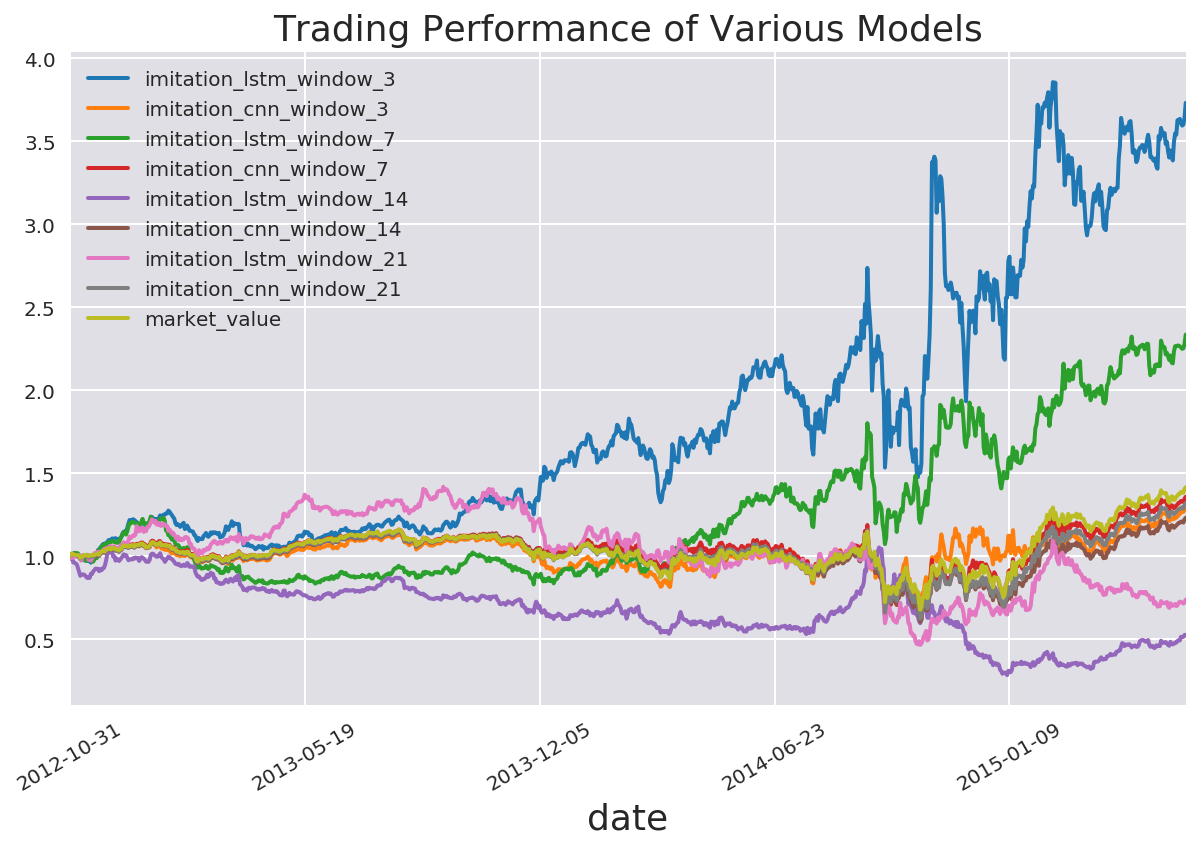

In [46]:
test_model_multiple(env, models[:8])

In [27]:
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[8:], steps=1500, 
                              sample_start_date='2012-10-30')

In [28]:
test_model_multiple(env, models[8:])

AssertionError: Invalid start date, must be window_length day after start date and simulation steps day before end date

In [ ]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[:8], steps=650, 
                              start_idx=num_training_time, sample_start_date=None)

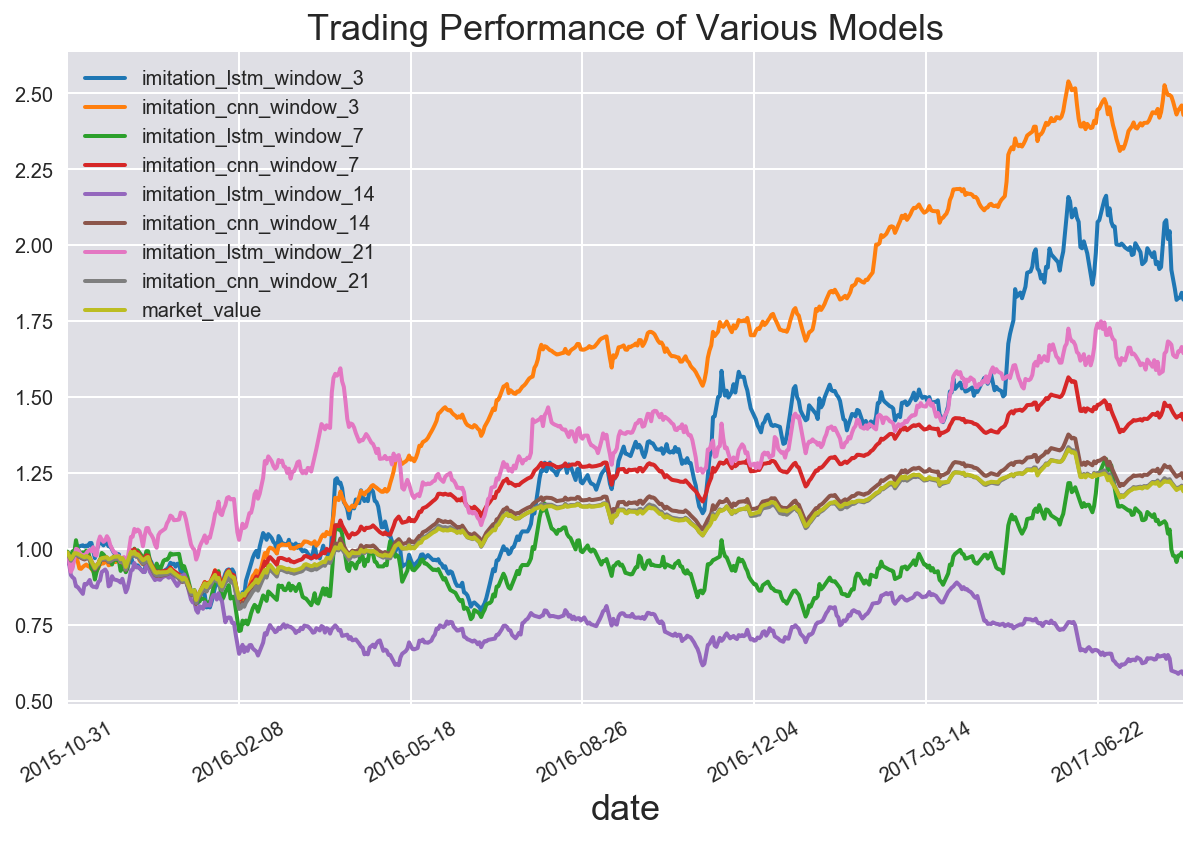

In [21]:
# test on CNN predictor, with batch norm and window length of 3
test_model_multiple(env, models[:8])

In [22]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[8:], steps=650, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

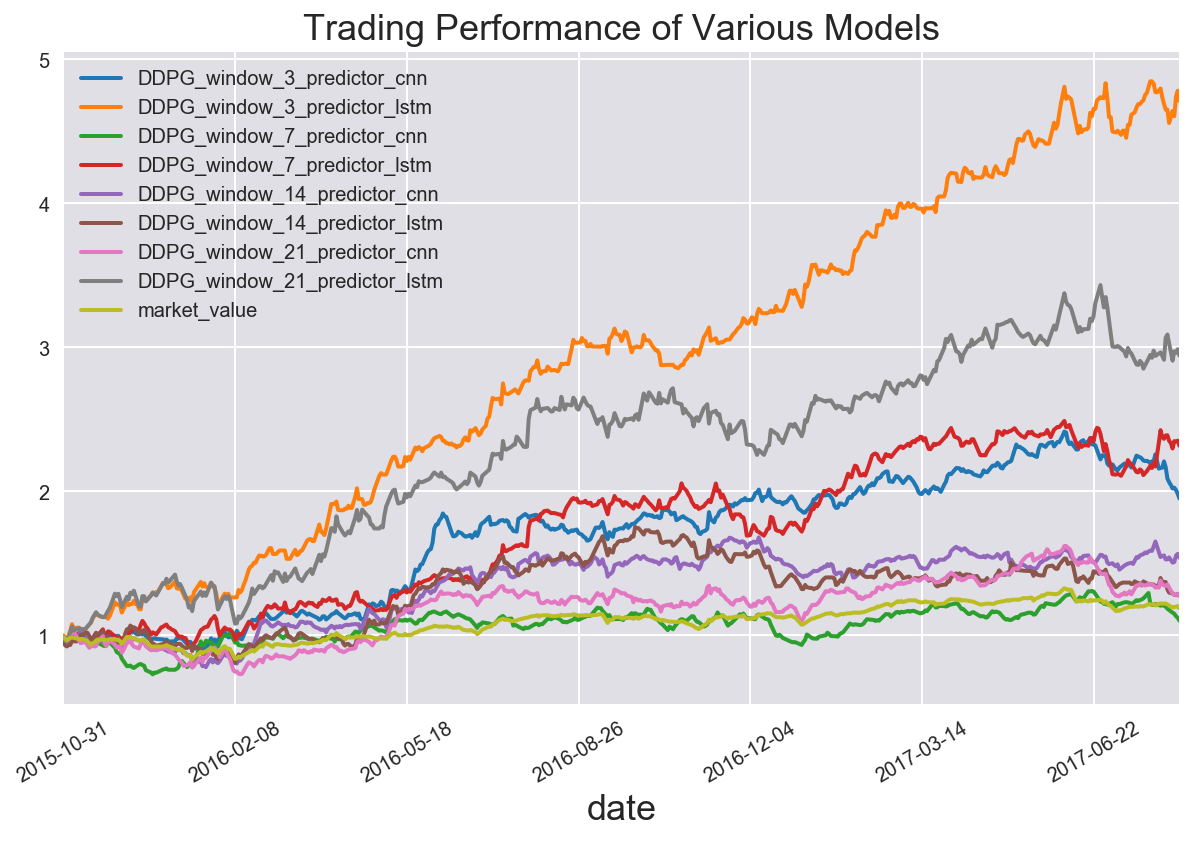

In [23]:
test_model_multiple(env, models[8:])

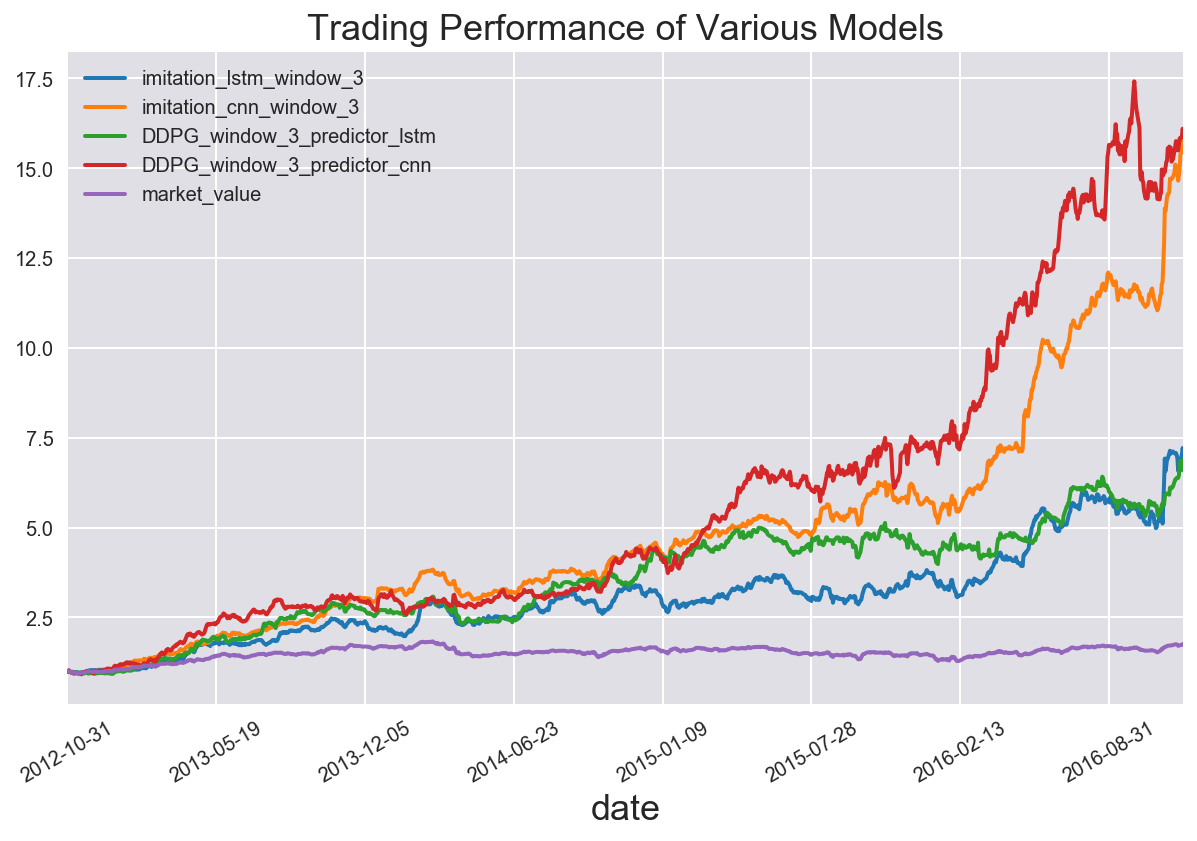

In [27]:
from environment.portfolio import MultiActionPortfolioEnv
selected_models = [models[0], models[1], models[9], models[8]]
selected_model_names = [model_names[0], model_names[1], model_names[9], model_names[8]]
env = MultiActionPortfolioEnv(target_history, target_stocks, selected_model_names, steps=1500, 
                              start_idx=0, sample_start_date='2012-10-30')
test_model_multiple(env, selected_models)

In [28]:
from model.supervised.imitation_optimal_action import *

In [29]:
# test on imitation learning
optimal_given_past_model = create_network_give_past(nb_classes, 3, 
                                        weight_path='weights/stock/imitation_16_stocks.h5')

Model load successfully


In [30]:
env = PortfolioEnv(testing_history, testing_stocks, steps=365, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

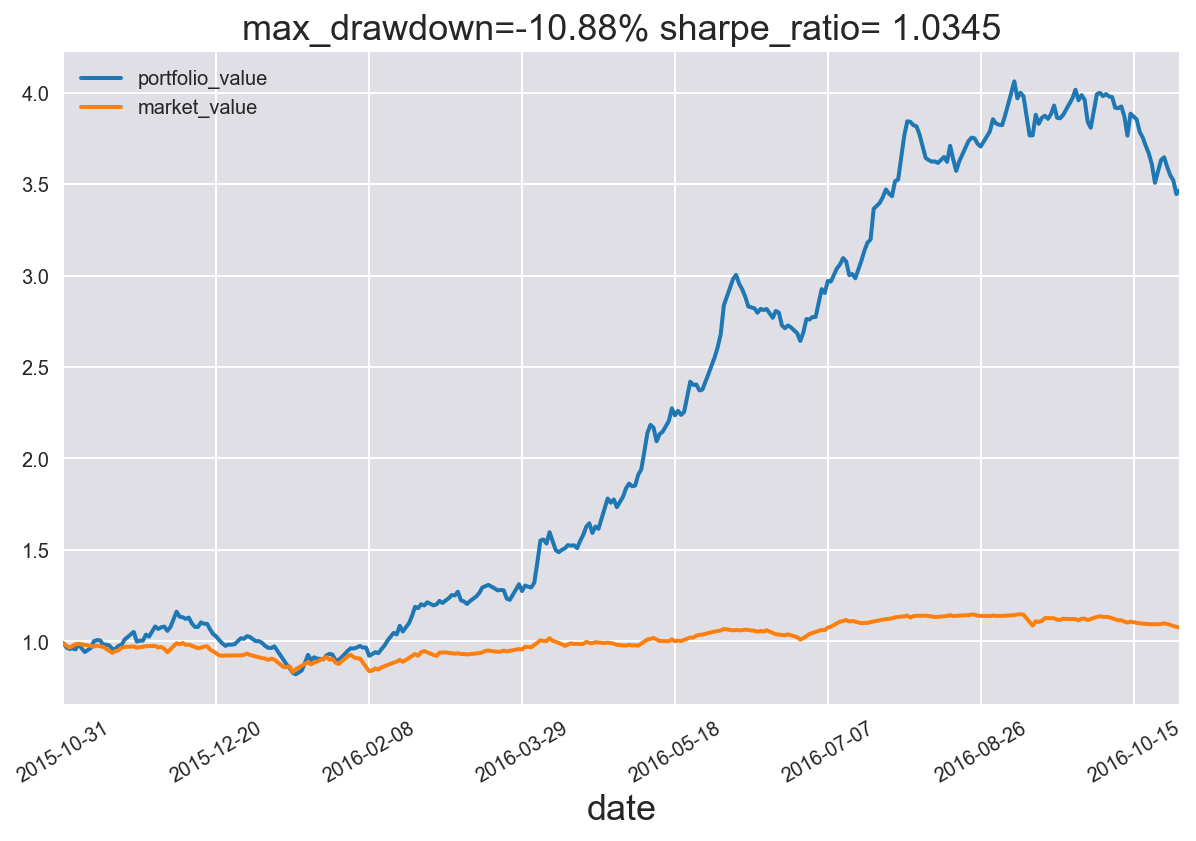

In [31]:
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.zeros((nb_classes,))
    close_open_ratio = close_open_ratio[:, -3:]
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    current_action_index = optimal_given_past_model.predict_classes(close_open_ratio, verbose=False)
    action[current_action_index] = 1.0
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()

In [11]:
# create another dataset
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target_2.h5')
history = history[:, :, :4]
nb_classes = len(history) + 1
print(history.shape)
testing_history = history
testing_stocks = abbreviation
target_history = history
target_stocks = abbreviation

(16, 1825, 4)
